#  Import Necessary Libraries

In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier

# 📥 Load the Data

In [70]:
email_df = pd.read_csv("email_table.csv")
opened_df = pd.read_csv("email_opened_table.csv")
clicked_df = pd.read_csv("link_clicked_table.csv")

# 🧹 Data Cleaning & Feature Engineering

In [71]:
email_df['is_opened'] = email_df['email_id'].isin(opened_df['email_id']).astype(int)
email_df['is_clicked'] = email_df['email_id'].isin(clicked_df['email_id']).astype(int)


In [72]:
email_df['email_text'] = email_df['email_text'].map({'short_email': 0, 'long_email': 1})
email_df['email_version'] = email_df['email_version'].map({'generic': 0, 'personalized': 1})


In [73]:
email_df.columns

Index(['email_id', 'email_text', 'email_version', 'hour', 'weekday',
       'user_country', 'user_past_purchases', 'is_opened', 'is_clicked'],
      dtype='object')

# 📊 Visualization 1: Bar Chart for Email Engagement

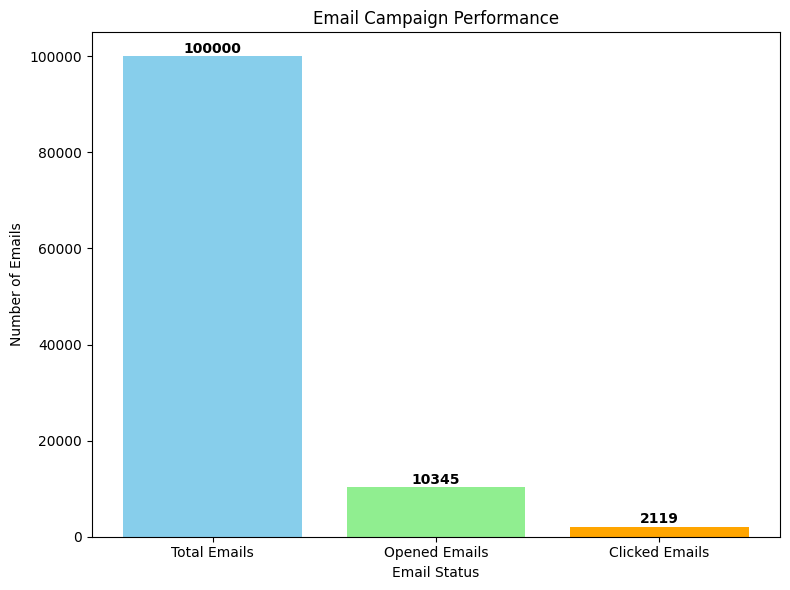

In [74]:
import matplotlib.pyplot as plt
import numpy as np


total_emails = len(email_df)
opened_emails = email_df['is_opened'].sum()
clicked_emails = email_df['is_clicked'].sum()


categories = ['Total Emails', 'Opened Emails', 'Clicked Emails']
values = [total_emails, opened_emails, clicked_emails]

plt.figure(figsize=(8, 6))
plt.bar(categories, values, color=['skyblue', 'lightgreen', 'orange'])
plt.title('Email Campaign Performance')
plt.ylabel('Number of Emails')
plt.xlabel('Email Status')


for i, v in enumerate(values):
    plt.text(i, v + 10, str(v), ha='center', va='bottom', fontweight='bold') # Adjust +10 for better label placement

plt.tight_layout()
plt.show()

Combine rare countries into 'Other

In [75]:
country_counts = email_df['user_country'].value_counts()
rare_countries = country_counts[country_counts < 50].index
email_df['user_country'] = email_df['user_country'].replace(rare_countries, 'Other')


# One-hot encode categorical columns

In [76]:
email_df = pd.get_dummies(email_df, columns=['user_country', 'weekday'], drop_first=True)


In [77]:
email_df['user_past_purchases'] = pd.cut(
    email_df['user_past_purchases'],
    bins=[-np.inf, 0, 1, 4, np.inf],
    labels=['0', '1', '2-4', '5+']
)

# 📊 Visualization 2: Click Rate by Past Purchases

<ipython-input-78-7cf26aba6584>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=email_df['user_past_purchases'], y=email_df['is_clicked'], estimator=np.mean, palette='viridis')


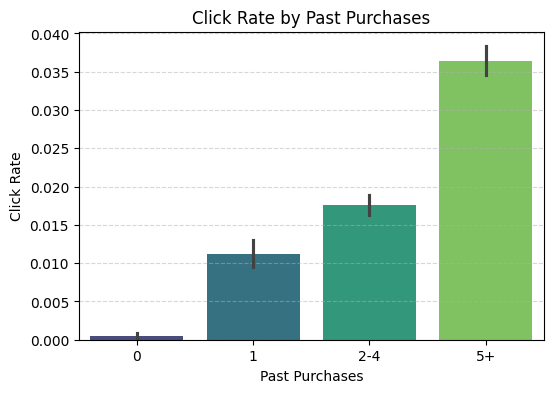

In [78]:
plt.figure(figsize=(6, 4))
sns.barplot(x=email_df['user_past_purchases'], y=email_df['is_clicked'], estimator=np.mean, palette='viridis')
plt.title('Click Rate by Past Purchases')
plt.ylabel('Click Rate')
plt.xlabel('Past Purchases')
plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.show()

In [79]:
email_df = pd.get_dummies(email_df, columns=['user_past_purchases'], drop_first=True)


# 🎯 Define Features and Target

In [80]:
X = email_df.drop(columns=['email_id', 'is_clicked'])
y = email_df['is_clicked']


# 🧪 Train-Test Split

In [81]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.40, random_state=42)


# 🤖 Train Logistic Regression

In [82]:


lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train, y_train)


LogisticRegression(max_iter=1000)

In [83]:
y_pred_lr = lr_model.predict(X_test)
y_proba_lr = lr_model.predict_proba(X_test)[:, 1]

# 📈 Evaluate Model

In [84]:

print("\n🔹 Logistic Regression")
print("Accuracy:", accuracy_score(y_test, y_pred_lr))
print("ROC AUC:", roc_auc_score(y_test, y_proba_lr))
print("Classification Report:\n", classification_report(y_test, y_pred_lr))


🔹 Logistic Regression
Accuracy: 0.978225
ROC AUC: 0.9535139869275753
Classification Report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99     39129
           1       0.00      0.00      0.00       871

    accuracy                           0.98     40000
   macro avg       0.49      0.50      0.49     40000
weighted avg       0.96      0.98      0.97     40000



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [85]:
email_df['click_proba_lr'] = lr_model.predict_proba(X)[:, 1]
top_30_lr = email_df[email_df['click_proba_lr'] >= email_df['click_proba_lr'].quantile(0.70)]
ctr_lr = top_30_lr['is_clicked'].mean() * 100
base_ctr = y.mean() * 100



# 📊 Compare Targeted CTR vs Original CTR
---



In [86]:
print(f"\nCTR - Logistic Regression")
print(f"Original CTR: {base_ctr:.2f}%")
print(f"Model-based Targeted CTR: {ctr_lr:.2f}%")
print(f"Potential Improvement: {ctr_lr - base_ctr:.2f}%")


CTR - Logistic Regression
Original CTR: 2.12%
Model-based Targeted CTR: 6.92%
Potential Improvement: 4.80%


<ipython-input-87-eb42ffdbc98e>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='is_clicked', data=email_df, palette='pastel')


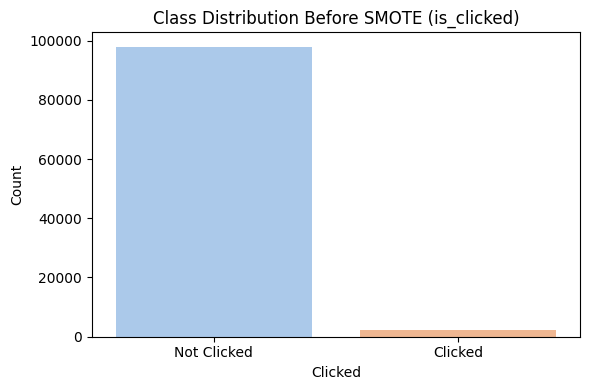

In [87]:
plt.figure(figsize=(6, 4))
sns.countplot(x='is_clicked', data=email_df, palette='pastel')
plt.title("Class Distribution Before SMOTE (is_clicked)")
plt.xlabel("Clicked")
plt.ylabel("Count")
plt.xticks([0, 1], ['Not Clicked', 'Clicked'])
plt.tight_layout()
plt.show()

In [88]:
smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)

# 🤖 Train XGBoost Model

In [89]:
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train_bal, y_train_bal)


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:57:16] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [90]:
y_pred = xgb_model.predict(X_test)
y_proba = xgb_model.predict_proba(X_test)[:, 1]

 📈 Evaluate Model


In [91]:
print("XGBoost Accuracy:", accuracy_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


XGBoost Accuracy: 0.9311
ROC AUC: 0.9407987662698545
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.93      0.96     39129
           1       0.21      0.78      0.33       871

    accuracy                           0.93     40000
   macro avg       0.60      0.86      0.65     40000
weighted avg       0.98      0.93      0.95     40000

Confusion Matrix:
 [[36561  2568]
 [  188   683]]


In [92]:
cv_scores = cross_val_score(xgb_model, X, y, cv=5, scoring='roc_auc') # Replace rf with xgb_model
print(f"\nCross-Validated AUC Scores: {cv_scores}")
print(f"Average AUC: {np.mean(cv_scores):.4f}")

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:57:17] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:57:17] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:57:18] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:57:19] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:57:20] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e


Cross-Validated AUC Scores: [0.94966786 0.95389149 0.95577198 0.9540601  0.9542622 ]
Average AUC: 0.9535


In [93]:
open_rate = email_df['is_opened'].mean() * 100
click_rate = email_df['is_clicked'].mean() * 100
print(f"Open Rate: {open_rate:.2f}%, Click Rate: {click_rate:.2f}%")


Open Rate: 10.35%, Click Rate: 2.12%


In [94]:
email_df['click_proba'] = xgb_model.predict_proba(X)[:, 1]
click_rate = email_df['is_clicked'].mean() * 100
top_30pct = email_df[email_df['click_proba'] >= email_df['click_proba'].quantile(0.70)]
model_based_ctr = top_30pct['is_clicked'].mean() * 100

# 📊 Compare Targeted CTR vs Original CTR

In [95]:
print(f"\nOriginal CTR: {click_rate:.2f}%")
print(f"Model-based Targeted CTR: {model_based_ctr:.2f}%")
print(f"Potential Improvement: {model_based_ctr - click_rate:.2f}%")


Original CTR: 2.12%
Model-based Targeted CTR: 6.97%
Potential Improvement: 4.85%


In [96]:
country_click_rate = email_df[[col for col in email_df.columns if col.startswith('user_country_')]].mean().sort_values(ascending=False) # Selecting the one-hot encoded country columns to get the click rates
print("\nClick rate by user_country:")
for country, rate in country_click_rate.items(): # Print the sorted results with the country names
    print(f'{country[13:]}: {rate:.2f}')


Click rate by user_country:
US: 0.60
UK: 0.20
FR: 0.10


<ipython-input-97-288b43a1390c>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances.head(15), y=importances.head(15).index, palette="viridis")


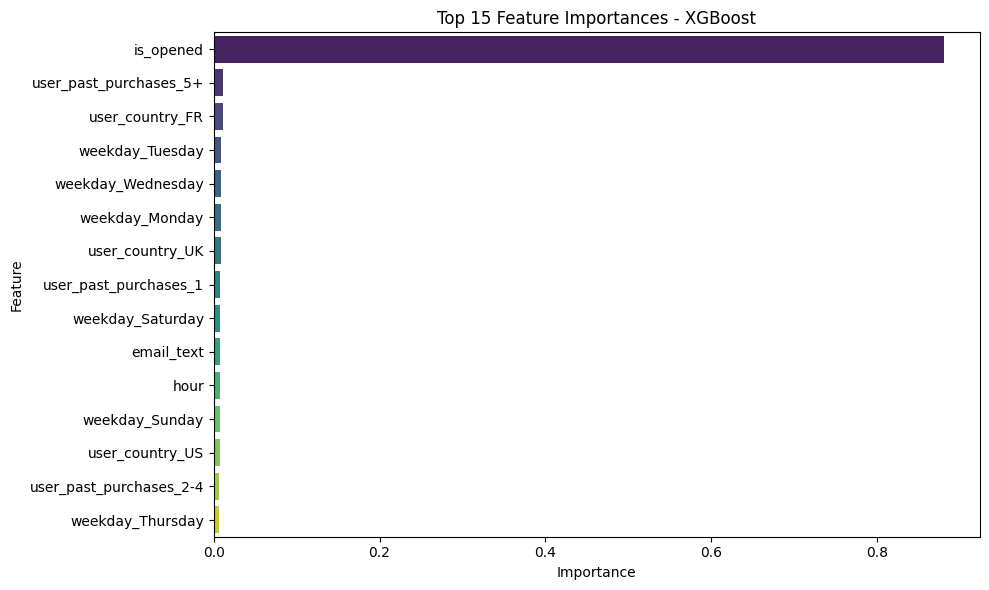

In [97]:
importances = pd.Series(xgb_model.feature_importances_, index=X.columns).sort_values(ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x=importances.head(15), y=importances.head(15).index, palette="viridis")
plt.title("Top 15 Feature Importances - XGBoost")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

In [98]:
email_df['click_proba_lr'] = lr_model.predict_proba(X)[:, 1]
top_30_lr = email_df[email_df['click_proba_lr'] >= email_df['click_proba_lr'].quantile(0.70)]
ctr_lr = top_30_lr['is_clicked'].mean() * 100
base_ctr = y.mean() * 100

email_df['click_proba_xgb'] = xgb_model.predict_proba(X)[:, 1]
top_30_xgb = email_df[email_df['click_proba_xgb'] >= email_df['click_proba_xgb'].quantile(0.70)]
ctr_xgb = top_30_xgb['is_clicked'].mean() * 100

In [99]:
print(f"\nCTR Comparison:")
print(f"Original CTR: {base_ctr:.2f}%")
print(f"Logistic Regression Targeted CTR: {ctr_lr:.2f}% | Improvement: {ctr_lr - base_ctr:.2f}%")
print(f"XGBoost Targeted CTR: {ctr_xgb:.2f}% | Improvement: {ctr_xgb - base_ctr:.2f}%")



CTR Comparison:
Original CTR: 2.12%
Logistic Regression Targeted CTR: 6.92% | Improvement: 4.80%
XGBoost Targeted CTR: 6.97% | Improvement: 4.85%
